<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

from random import randint
from urllib.request import urlopen

from numpy import asarray

In [26]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)

In [27]:
df.head(3)

,id,sku,short_description,price,discount,discount_rate,rating_average,review_count,order_count,favourite_count,thumbnail_url,categories,liked,rating_summary,brand,current_seller,other_sellers,configurable_options,extra_feature,cloth_type
0,0,4777164499549,\n \n- Loại : Quần Thể Thao Đen.\n- Kiểu Dáng ...,99000,101000,51,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 36387, ""sku"": ""5716562721707"", ""store_i...","[{""id"": 134556, ""name"": ""Mualayeushop"", ""link""...","[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],top_t-shirt_sweatshirt shoe pants
1,1,2931572867679,\nÁo Len Nam Dày Bs33 được may từ chất liệu le...,400000,0,0,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 2, ""name"": ""Root"", ""is_leaf"": false}",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 10025, ""sku"": ""4689826428364"", ""store_i...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[],sweater
2,2,6427102533481,\n \n- Loại : Quần Âu Thêu Vương Miện\n- Kiểu ...,159000,141000,47,4.5,14,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 9674, ""sku"": ""5288509925221"", ""store_id...",[],"[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],watch shoe shirt_blouse pants


In [28]:
from random import randint
from urllib.request import urlopen

In [29]:
total_images = df.thumbnail_url.notna().sum()
total_images

4705

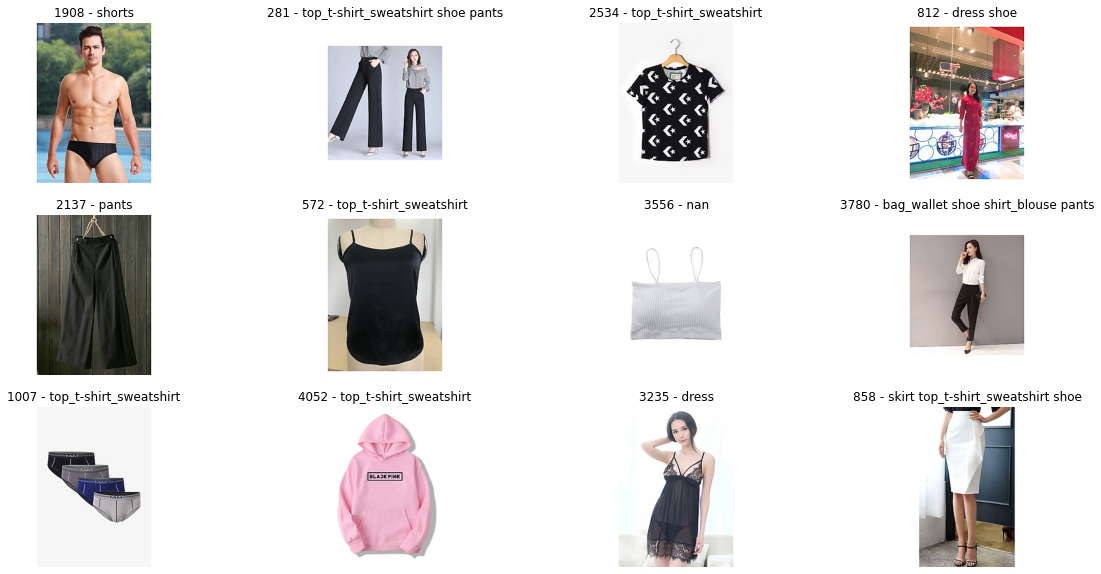

In [30]:
# plot random 12 image
fig = plt.figure(figsize=(20,10))
for i in range(0,12):
  ax = plt.subplot(3,4,i+1)
  _i = randint(0,total_images)
  img = Image.open(urlopen(df.thumbnail_url[_i]))
  ax = plt.imshow(img)
  plt.title(f"{_i} - {df.cloth_type[_i]}")
  plt.axis("off")

# Check for label

In [31]:
df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN

In [32]:
# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]
labels[:5]

[['top_t-shirt_sweatshirt', 'shoe', 'pants'],
 ['sweater'],
 ['watch', 'shoe', 'shirt_blouse', 'pants'],
 ['belt', 'dress', 'bag_wallet', 'shoe'],
 ['bag_wallet', 'dress', 'shoe']]

In [33]:
# Count the apperence of label
all_label = [label for sub in labels for label in sub]
labels_count = Counter(all_label)
labels_count

Counter({'bag_wallet': 438,
         'belt': 410,
         'cardigan': 31,
         'coat': 152,
         'dress': 768,
         'glasses': 119,
         'hat': 195,
         'headband_head-covering_hair-accessory': 99,
         'jacket': 414,
         'jumpsuit': 25,
         'nan': 283,
         'pants': 1616,
         'scarf': 5,
         'shirt_blouse': 480,
         'shoe': 1520,
         'shorts': 479,
         'skirt': 750,
         'sweater': 116,
         'top_t-shirt_sweatshirt': 2382,
         'vest': 4,
         'watch': 463})


Create Mapping

In [34]:
labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

In [35]:
label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}

In [36]:
inv_label_map

{0: 'top_t-shirt_sweatshirt',
 1: 'pants',
 2: 'shoe',
 3: 'dress',
 4: 'skirt',
 5: 'shirt_blouse',
 6: 'shorts',
 7: 'watch',
 8: 'bag_wallet',
 9: 'jacket',
 10: 'belt',
 11: 'nan',
 12: 'hat',
 13: 'coat',
 14: 'glasses',
 15: 'sweater',
 16: 'headband_head-covering_hair-accessory',
 17: 'cardigan',
 18: 'jumpsuit',
 19: 'scarf',
 20: 'vest'}


Whichs are the tops used label?

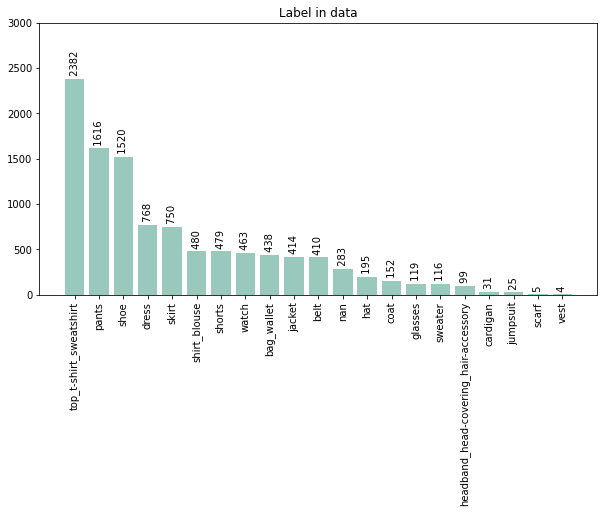

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.bar(label_name, label_freq, color="#99C8BC")
plt.title("Label in data")
plt.xticks(rotation=90)
for i, (tag,count) in enumerate(labels_count.most_common()):
  plt.text(i, count, f" {count} ", rotation=90, ha="center", va="bottom", color="black")
plt.ylim(0,3000);

Create a one hot encoding for one list of tags

In [11]:
from numpy import asarray

In [30]:
def one_hot_encoder(tags, mapping):
  # create empty vector
  encoding = np.zeros(len(label_map), dtype="uint")
  # mark 1 for each tag in the vector
  for tag in tags:
    encoding[label_map[tag]] = 1
  return encoding

In [31]:
def load_dataset(images_url, labels, label_map):
  # images,  targets = list(), list()
  images = []
  targets = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    if img.mode != 'RGB': img = img.convert('RGB')

    # turn image in to array
    img = asarray(img)
    tags = labels[i]
    target = one_hot_encoder(tags, label_map)

    images.append(img)
    targets.append(target)

  X = asarray(images, dtype="uint8")
  y = asarray(targets, dtype="uint8")

  return X, y

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

''

In [ ]:
X, y = load_dataset(df.thumbnail_url, labels, label_map)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna_21.npz", X, y)

In [12]:

data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


# How to evaluate model

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [15]:
train_yhat = asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])

In [16]:

from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

In [17]:
fbeta_score(y_train, train_yhat, beta=2, average='samples')

0.3545051627434874

In [18]:
f1_score(y_train, train_yhat, average='samples')

0.19044924451636544

In [19]:
X_train.shape

(3152, 280, 280, 3)

# Baseline Model

In [20]:
import sys
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

In [21]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [22]:
fbeta(y_train, train_yhat, beta=2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3545051332827347>

In [23]:
def define_model(in_shape=(280,280,3), out_shape=21):
  model = Sequential()
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer="he_uniform",
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu",kernel_initializer="he_uniform",))
  model.add(Dropout(0.5))
  model.add(Dense(out_shape, activation="sigmoid"))

  # Compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[fbeta])

  return model

In [19]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [27]:
datagen = ImageDataGenerator(rescale=1.0/225.0)
train_it = datagen.flow(X_train, y_train, batch_size=128)
test_it = datagen.flow(X_test, y_test, batch_size=128)
model = define_model()

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 280, 280, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 280, 280, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 140, 140, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 70, 64)       

In [29]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=50)

Epoch 1/50
25/25 [==============================] - 72s 2s/step - loss: 0.5010 - fbeta: 0.2087 - val_loss: 0.4420 - val_fbeta: 0.2110
Epoch 2/50
25/25 [==============================] - 44s 2s/step - loss: 0.3191 - fbeta: 0.2154 - val_loss: 0.4135 - val_fbeta: 0.3290
Epoch 3/50
25/25 [==============================] - 44s 2s/step - loss: 0.3056 - fbeta: 0.2028 - val_loss: 0.4326 - val_fbeta: 0.3031
Epoch 4/50
25/25 [==============================] - 44s 2s/step - loss: 0.2985 - fbeta: 0.1920 - val_loss: 0.4184 - val_fbeta: 0.3109
Epoch 5/50
25/25 [==============================] - 44s 2s/step - loss: 0.2973 - fbeta: 0.1926 - val_loss: 0.4328 - val_fbeta: 0.3099
Epoch 6/50
25/25 [==============================] - 44s 2s/step - loss: 0.2917 - fbeta: 0.1839 - val_loss: 0.3992 - val_fbeta: 0.3081
Epoch 7/50
25/25 [==============================] - 44s 2s/step - loss: 0.2896 - fbeta: 0.1968 - val_loss: 0.3852 - val_fbeta: 0.3322
Epoch 8/50
25/25 [==============================] - 44s 2s/ste

In [30]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_dropout_sigmoid_heuni_sgd/model_dropout_sigmoid_heuni_sgd')

In [31]:
model.load_weights('/content/drive/MyDrive/01_AI_ML/sss/model_dropout_sigmoid_heuni_sgd/model_dropout_sigmoid_heuni_sgd')

In [32]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [33]:
predictions = model.predict(test_data)

In [34]:
def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

In [35]:
prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]

In [36]:
prediction_tags
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

In [ ]:
# plot random 9 image
fig = plt.figure(figsize=(20,10))
for i in range(0,9):
  ax = plt.subplot(3,3,i+1)
  _i = randint(0,len(test_data))
  ax = plt.imshow(test_data[_i])
  plt.title(f"{_i} - {prediction_tags[_i]}")
  plt.axis("off")

In [38]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

In [39]:
submission["cloth_type"] = submission.cloth_type.str.replace("nan","")

In [42]:
submission[50:70]

,id,cloth_type
50,4755,pants
51,4756,
52,4757,
53,4758,top_t-shirt_sweatshirt pants shoe
54,4759,pants shoe
55,4760,
56,4761,top_t-shirt_sweatshirt pants dress
57,4762,shoe dress
58,4763,top_t-shirt_sweatshirt pants
59,4764,top_t-shirt_sweatshirt dress


In [43]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v3_dropout_sigmoid_sgd.csv', index=False)

# Use transfer learning

In [6]:
import numpy as np

In [1]:
import sys 
from numpy import load
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [4]:
def define_model(in_shape=(280,280,3),out_shape=21):
  # load model
  model = VGG16(include_top=False, input_shape=in_shape)

  # marked loaded layers not trainable
  for layer in model.layers:
    layer.trainable = False
  
  # add new chalsifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer="he_uniform")(flat1)
  output = Dense(out_shape, activation="sigmoid")(class1)
  # define new model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
  return model

In [7]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [10]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.778, 103.939]
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)
model = define_model()

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 280, 280, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 280, 280, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 280, 280, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 140, 140, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 140, 140, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 140, 140, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 70, 70, 128)       0     

In [12]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=20)

Epoch 1/20
50/50 [==============================] - 130s 2s/step - loss: 1.1801 - fbeta: 0.2735 - val_loss: 0.3087 - val_fbeta: 0.3381
Epoch 2/20
50/50 [==============================] - 58s 1s/step - loss: 0.2907 - fbeta: 0.2197 - val_loss: 0.2947 - val_fbeta: 0.3225
Epoch 3/20
50/50 [==============================] - 58s 1s/step - loss: 0.2671 - fbeta: 0.2489 - val_loss: 0.2705 - val_fbeta: 0.3454
Epoch 4/20
50/50 [==============================] - 57s 1s/step - loss: 0.2510 - fbeta: 0.2902 - val_loss: 0.2735 - val_fbeta: 0.2654
Epoch 5/20
50/50 [==============================] - 58s 1s/step - loss: 0.2397 - fbeta: 0.3642 - val_loss: 0.2715 - val_fbeta: 0.0888
Epoch 6/20
50/50 [==============================] - 58s 1s/step - loss: 0.2287 - fbeta: 0.4004 - val_loss: 0.2548 - val_fbeta: 0.4839
Epoch 7/20
50/50 [==============================] - 58s 1s/step - loss: 0.2164 - fbeta: 0.4226 - val_loss: 0.2653 - val_fbeta: 0.4511
Epoch 8/20
50/50 [==============================] - 58s 1s/st

In [13]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_vvg16/model_vvg16')

In [14]:
loss, fbeta = model.evaluate(test_it, steps=len(test_it))

25/25 [==============================] - 19s 761ms/step - loss: 0.2610 - fbeta: 0.4854


In [15]:
print(f"> loss = {loss:.3f}, f1-mean = {fbeta:.3f}")

> loss = 0.261, f1-mean = 0.485


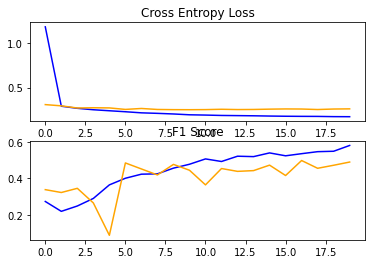

In [18]:
summarize_diagnostics(history)

In [19]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [20]:
predictions = model.predict(test_data)

In [22]:
def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

In [37]:
prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]

In [38]:
prediction_tags
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

In [39]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

In [40]:
submission["cloth_type"] = submission.cloth_type.str.replace("nan","")

In [41]:
submission[50:70]

,id,cloth_type
50,4755,top_t-shirt_sweatshirt dress
51,4756,
52,4757,top_t-shirt_sweatshirt dress
53,4758,pants shoe
54,4759,pants shoe shirt_blouse
55,4760,top_t-shirt_sweatshirt
56,4761,pants shoe
57,4762,top_t-shirt_sweatshirt dress
58,4763,pants shoe
59,4764,top_t-shirt_sweatshirt


In [44]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v4_model_vvg16.csv', index=False)